# compute rotary specta of ageostrophic currents

Steps taken are:

- data rewriting with more appropriate chunks

- computation of spectra

- zonally averages it


In [27]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
from scipy.signal import welch
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *

In [12]:
from dask_jobqueue import PBSCluster
# for heavy processing:
cluster = PBSCluster(cores=6, processes=6, walltime='12:00:00')
w = cluster.scale(6*40)
# for zonal averaging post processing:
#cluster = PBSCluster(cores=12, processes=12, walltime='12:00:00')
#w = cluster.scale(40*12)
#w = cluster.scale(10*12)

In [13]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [14]:
cluster

In [16]:
client

Client Scheduler: tcp://10.135.39.59:36209 Dashboard: http://10.135.39.59:8787/status,Cluster Workers: 240 Cores: 240 Memory: 4.00 TB


---
## Load and rechunk original data

In [17]:
# parameters for rechunking: time and space
Nt, Ni, Nj = 0, 188, 96

V = ['u','v']
terms = ['coriolis_linear','gradp']

### rechunk one face at a time

In [25]:
overwrite=False

for v in V:

    print('--- Start '+v)
        
    #for face in range(13):
    for face in [1]:
        
        ds = xr.merge([xr.open_zarr(work_data_dir+'mbal/'+v+'_'+t+'_f%02d.zarr'%face) 
                   for t in terms])
        
        if Nt ==0:
            Nt = len(ds.time)
        it = slice(len(ds.time)//Nt *Nt)
        
        ds = ds.isel(time=it)
        #
        chunks = {'time': Nt, 'i': Ni, 'j': Nj}
        if v is 'u':
            chunks = {'time': Nt, 'i_g': Ni, 'j': Nj}
        elif v is 'v':
            chunks = {'time': Nt, 'i': Ni, 'j_g': Nj}
        ds = ds.chunk(chunks)
        
        # tmp, xarray zarr backend bug: 
        # https://github.com/pydata/xarray/issues/2278
        #del ds['iters'].encoding['chunks']
        for t in terms:
            del ds[v+'_'+t].encoding['chunks']
        
        file_out = work_data_dir+'rechunked/%s_mbal_f%02d.zarr'%(v,face)
        #print(ds)
        if not os.path.isdir(file_out) or overwrite:
            %time ds.to_zarr(file_out, mode='w')
            # about 2min for NT = 24*20*4
            
        print(' %s face=%d  done ' %(v, face))

--- Start u


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:            (i_g: 4320, j: 4320, time: 8640)
Coordinates:
    dxC                (j, i_g) float32 dask.array<shape=(4320, 4320), chunksize=(96, 188)>
    dyG                (j, i_g) float32 dask.array<shape=(4320, 4320), chunksize=(96, 188)>
    f_j                (j, i_g) float32 dask.array<shape=(4320, 4320), chunksize=(96, 188)>
    face               int64 1
  * i_g                (i_g) int64 0 1 2 3 4 5 ... 4314 4315 4316 4317 4318 4319
  * j                  (j) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * time               (time) float64 5.702e+06 5.706e+06 ... 3.68e+07 3.68e+07
Data variables:
    u_coriolis_linear  (j, i_g, time) float32 dask.array<shape=(4320, 4320, 8640), chunksize=(96, 188, 8640)>
    u_gradp            (time, j, i_g) float32 dask.array<shape=(8640, 4320, 4320), chunksize=(8640, 96, 188)>


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 3min 38s, sys: 14.7 s, total: 3min 53s
Wall time: 7min 49s
 u face=1  done 
--- Start v
<xarray.Dataset>
Dimensions:            (i: 4320, j_g: 4320, time: 8640)
Coordinates:
    dxG                (j_g, i) float32 dask.array<shape=(4320, 4320), chunksize=(96, 188)>
    dyC                (j_g, i) float32 dask.array<shape=(4320, 4320), chunksize=(96, 188)>
    f_i                (j_g, i) float32 dask.array<shape=(4320, 4320), chunksize=(96, 188)>
    face               int64 1
  * i                  (i) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * j_g                (j_g) int64 0 1 2 3 4 5 ... 4314 4315 4316 4317 4318 4319
  * time               (time) float64 5.702e+06 5.706e+06 ... 3.68e+07 3.68e+07
Data variables:
    v_coriolis_linear  (j_g, i, time) float32 dask.array<shape=(4320, 4320, 8640), chunksize=(96, 188, 8640)>
    v_gradp            (time, j_g, i) float32 dask.array<shape=(8640, 4320, 4320), chunksize=(8640, 96, 188)>
CPU times: user 3min 39s,

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [15]:
cluster.close()

---

## rotary spectra

In [26]:
#grd = load_grd(ftype='nc').reset_coords()
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
print(grd_rspec)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mask     (face, j, i) bool dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>


/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [62]:
# spatial strides for decimation
dij=4
overwrite=False
    
#for face in range(13):
for face in [1]:

    Efile = work_data_dir+'mbal/E_ageo_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        # load data
        dsu = ( xr.open_zarr(work_data_dir+'rechunked/%s_mbal_f%02d.zarr'%('u',face))
                .isel(i_g=slice(0,None,dij), j=slice(0,None,dij)) )
        dsv = (xr.open_zarr(work_data_dir+'rechunked/%s_mbal_f%02d.zarr'%('v',face))
               .isel(i=slice(0,None,dij), j_g=slice(0,None,dij)) )
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))

        # !!! check signs, will need to be normalized by Coriolis frequency !!!
        # compute ageostrophic velocities
        ds['u_ageo'] = -ds['v_gradp'] +  ds['v_coriolis_linear']
        ds['v_ageo'] =  ds['u_gradp'] -  ds['u_coriolis_linear']
        
        # generate a complex vector variable
        ds['uv_ageo'] = ds['u_ageo'].fillna(0.) + 1j * ds['v_ageo'].fillna(0.)    

        # should show the size of the dataset to know if we can load it in memory
        print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

        # spectral computation
        # need to run once to get frequency line
        f, E = get_E(ds['uv_ageo'].isel(i=2,j=2))
        #
        E = get_E(ds['uv_ageo'], f=f)

        # store
        E = E.to_dataset()
        for c in E.coords:
            try:
                del E[c].encoding['chunks']
            except:
                print(c)        
        E = E.chunk({'i': 24*8, 'j':47*4})
        %time E.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)
                

dataset size: 322.5 GB
mask
freq_time
--- face 1 done


/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [ ]:
cluster.close()

### inspect result

In [71]:
face=1
v = 'uv_ageo'
E = xr.open_zarr(work_data_dir+'mbal/E_ageo_f%02d.zarr'%(face))[v].fillna(0.)
E = E.persist()
print(E)
print('\n data size: %.1f GB' %(E.nbytes / 1e9))

<xarray.DataArray 'uv_ageo' (j: 1080, i: 1080, freq_time: 1440)>
dask.array<shape=(1080, 1080, 1440), dtype=float64, chunksize=(188, 192, 1440)>
Coordinates:
    Depth      (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(188, 192)>
    XC         (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(188, 192)>
    YC         (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(188, 192)>
    dxC        (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(188, 192)>
    dxG        (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(188, 192)>
    dyC        (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(188, 192)>
    dyG        (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(188, 192)>
    f_i        (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(188, 192)>
    f_j        (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(188, 192)>
    face       int64 ...
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


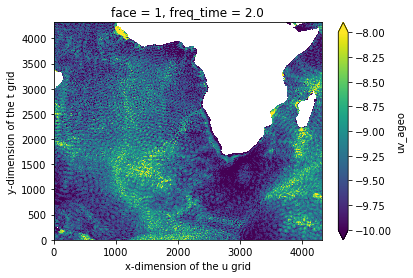

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [75]:
np.log10(E.sel(freq_time=2., method='nearest')).plot(vmin=-10,vmax=-8)

### !!! Needs to be updated from here !!!


### concatenate all faces

In [15]:
v='SSUV'
E = xr.concat([xr.open_zarr(work_data_dir+'tmp/%s_f%02d.zarr'%(v,face)) 
               for face in F], dim='face', compat='identical')
#E = E.chunk({'i': 24, 'j':12})
print(E)
%time E.to_zarr(work_data_dir+'tmp/%s.zarr'%(v), mode='w')

<xarray.Dataset>
Dimensions:    (face: 2, freq_time: 1920, i: 1080, j: 1080)
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    Depth      (face, j, i) float32 0.0 0.0 0.0 0.0 ... 2531.0693 2131.7 2131.7
    XC         (face, j, i) float32 -114.93228 -114.93183 ... 51.84375 51.927082
    YC         (face, j, i) float32 -88.17715 -88.18883 ... 13.672233 13.672233
  * face       (face) int64 0 1
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<shape=(2, 1080, 1080, 1920), chunksize=(1, 24, 47, 1920)>
CPU times: user 13.1 s, sys: 837 ms, total: 14 s
Wall time: 23.5 s


---

## zonal averages

In [16]:
v='SSUV'
# concatenates faces
#ds = xr.concat([xr.open_zarr(work_data_dir+'spectra/%s_f%02d.zarr'%(v,face))
#               .chunk({'i': 24, 'j':12}) 
#               for face in range(13)], dim='face', compat='identical')
# or load concatenated spectra
ds = xr.open_zarr(work_data_dir+'tmp/%s.zarr'%(v)) #.isel(face=slice(0,2))
ds = ds.drop(['XC'])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:    (face: 2, freq_time: 1920, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(2, 1080, 1080), chunksize=(1, 270, 540)>
    YC         (face, j, i) float32 dask.array<shape=(2, 1080, 1080), chunksize=(1, 270, 540)>
  * face       (face) int64 0 1
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<shape=(2, 1080, 1080, 1920), chunksize=(1, 24, 47, 1920)>

 data size: 35.9 GB


In [17]:
latb = np.arange(-60.,60.,1.)
latc = (latb[:-1]+latb[1:])*.5

def _zhist(x, lat, weights=True):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    if weights:
        w = x
    else:
        w = np.ones_like(x)
    h, edges = np.histogram(lat, bins=latb, weights=w, density=False)
    return h[None,:]

def zaverage(v):
    dims = ['i','j']
    v = v.fillna(0.)
    lat = v.YC+0.*v
    #
    S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    S = S.assign_coords(latitude=latc).rename('S_SSUV')
    #
    W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    W = W.assign_coords(latitude=latc).rename('W_SSUV')    
    return xr.merge([S, W], compat='identical')

In [18]:
for face in F:
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    E = lds.SSUV.where(lds.Depth>200., drop=False) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'tmp/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

--- face 0 done
--- face 1 done


### Reload data, completes the zonal averaging and plot

In [19]:
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'tmp/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1920, latitude: 119)>
dask.array<shape=(1920, 119), dtype=float64, chunksize=(1920, 119)>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


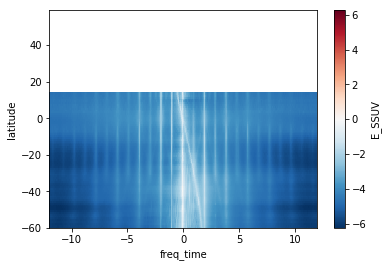

In [20]:
np.log10(E_zav).plot(x='freq_time', y='latitude')

---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [21]:
cluster.close()